# Detector Data Imputation Project 


PeMS have over 40, 000 detectors across the state to record traffic parameters (such as occupancy, volume and speed) and report highway performance (e.g. Congestion, Delay) 

However, PeMS traffic parameters are often missing due to malfunction of the sensors, which impacts data quality and performance metrics


Current data imputation method:
1. Linear regression from local neighbors
2. Linear regression from global neighbors 
3. Temporal medians
4. Cluster medians (based on detectors with similar traffic patterns)

Goal: impute the missing detector measurements using a unified machine learning model 



In [212]:
import numpy as np
import pandas as pd
import datetime
from data_processing import *

# Define the start and end dates
start_date = datetime(2023, 7, 1)
end_date = datetime(2024, 3, 31)

df_detector_id = pd.read_csv(r"C:\Users\p309996\OneDrive - California Department of Transportation\Desktop\ml project v2\pems_detector_config_log_10012023.csv")
# Replace NaN values with -1
df_detector_id['LANE'].fillna(1, inplace=True)
# Convert the column to integers
df_detector_id['LANE'] = df_detector_id['LANE'].astype(int)

df_station_metadata = pd.read_csv(r'C:\Users\p309996\OneDrive - California Department of Transportation\Desktop\XInyue Project\data\d03_text_meta_2024_04_11.txt', delimiter = "\t")
df_station_metadata = df_station_metadata[df_station_metadata["Type"]=="ML"]

from_folder = "C:/Users/p309996/OneDrive - California Department of Transportation\Desktop/XInyue Project/data/unzipped data/"
to_folder = "C:/Users/p309996/OneDrive - California Department of Transportation/Desktop/XInyue Project/ML project/Modules/data/processed_data/"

zip_file_list = initialize_zip_file_list(start_date, end_date)
station_list = find_station_list(df_station_metadata[df_station_metadata["Fwy"]==80], df_detector_id)
# if run the model for all district 3 data, use this line of code instead of I80 
#station_list = find_station_list(df_station_metadata, df_detector_id)

# data_convert_ordered(start_date, end_date, from_folder, to_folder, station_list, df_detector_id)


Before filtering, the sensor number =  201
After filtering, the sensor number =  145


## Data tables

#### Station 5min data (main data table)
This data table contains daily measurements at each station for every 5-minute interval. 
This data table can be downloaded daily from PeMS data clearing house: https://pems.dot.ca.gov/feeds/clhouse/d03/ 
This data table contains critical information such as station_id, location (highway and its postmile), number of detectors, and measurements.

Detailed column extraction method can be found in function **data_processing.data_convert_ordered()**.

In [3]:
(pd.read_csv(from_folder+'d03_text_station_5min_2023_07_01.txt', header=None)).head()


,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,07/01/2023 00:00:00,308511,3,50,E,ML,3.134,20,100,4.0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
1,07/01/2023 00:00:00,308512,3,50,W,ML,3.995,12,0,58.0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2,07/01/2023 00:00:00,311832,3,5,S,FR,NaN,10,0,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
3,07/01/2023 00:00:00,311844,3,5,N,OR,NaN,0,0,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
4,07/01/2023 00:00:00,311847,3,5,N,OR,NaN,0,0,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0


#### Detector data
`df_detector_id` contains the unique detector_id for each detector. Since the original data table contains only station_id, this table bridges the station_id to detector_id.

In [4]:
df_detector_id.head()

,EQUIPMENT_SET,DETECTOR_ID,TIME_ID,STATION_ID,STATUS,LANE,SLOT,VOLUME_FLAG,LOGICAL_POSITION
0,27814,816395,3-Oct-23,816401,1,1,1.0,0.0,6.0
1,27814,816396,3-Oct-23,816401,1,2,2.0,0.0,7.0
2,27814,816397,3-Oct-23,816401,1,3,3.0,0.0,8.0
3,27814,816398,3-Oct-23,816401,1,4,4.0,0.0,14.0
4,27814,820327,3-Oct-23,820328,1,1,1.0,0.0,17.0


#### Station Metadata

In [214]:
df_station_metadata.head()

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4
0,308511,50,E,3,17,NaN,31.627,60.162,38.761062,-120.569835,3.134,ML,2,Sly Park Rd,1,NaN,NaN,NaN
1,308512,50,W,3,17,NaN,31.627,60.166,38.761182,-120.569866,3.995,ML,2,Sly Park Rd,1,NaN,NaN,NaN
7,311903,50,E,3,67,64000.0,L0.633,3.789,38.566906,-121.505888,0.883,ML,3,50EB at 6TH Street,1,NaN,NaN,NaN
10,311974,50,E,3,67,64000.0,L1.22,4.376,38.564153,-121.495585,0.466,ML,5,15th St,1,NaN,NaN,NaN
12,312010,50,W,3,67,64000.0,L1.345,4.501,38.563816,-121.493316,0.752,ML,5,15th St,1,NaN,NaN,NaN


### Data processing and filtering
To ensure we have the right data to work with, we filtered the stations (mainline) with data throughout 2024/07/01 - 2024/03/30. For detectors, we only keep detectors with an unchanged lane_id. There are 2 detectors changed lane_id during the time period (maybe a new lane is added to the left of highway). This is for the convenience (with fixed and known target column) to retrieve data in the 5min station datatable. 

In [5]:

from data_filtering import *
# station_list = get_station_list(zip_file_list, df_detector_id, df_station_metadata)
station_list, detector_list, station_to_detector_dict = get_detector_list(df_detector_id, station_list)
station_list_by_highway,highway_list, station_dist_list_by_highway = get_station_list_by_highway(station_list, df_station_metadata)
neighbor_stations_dict = get_station_neighbors(station_list_by_highway, station_dist_list_by_highway, max_dist=1)
detector_to_station_dict = get_detector_to_station_dict(station_list, station_to_detector_dict)
detector_lane_dict = get_detector_lane_dict(df_detector_id, detector_list)
neighbor_detectors_dict = get_detector_neighbors(detector_list, station_to_detector_dict, detector_to_station_dict, neighbor_stations_dict, detector_lane_dict)


Lists of stations and detectors are created to extract data. Dictionaries are created and neighboring sensors are found for each detector. Here only detectors within 1 mile are consdiered neighbors. 

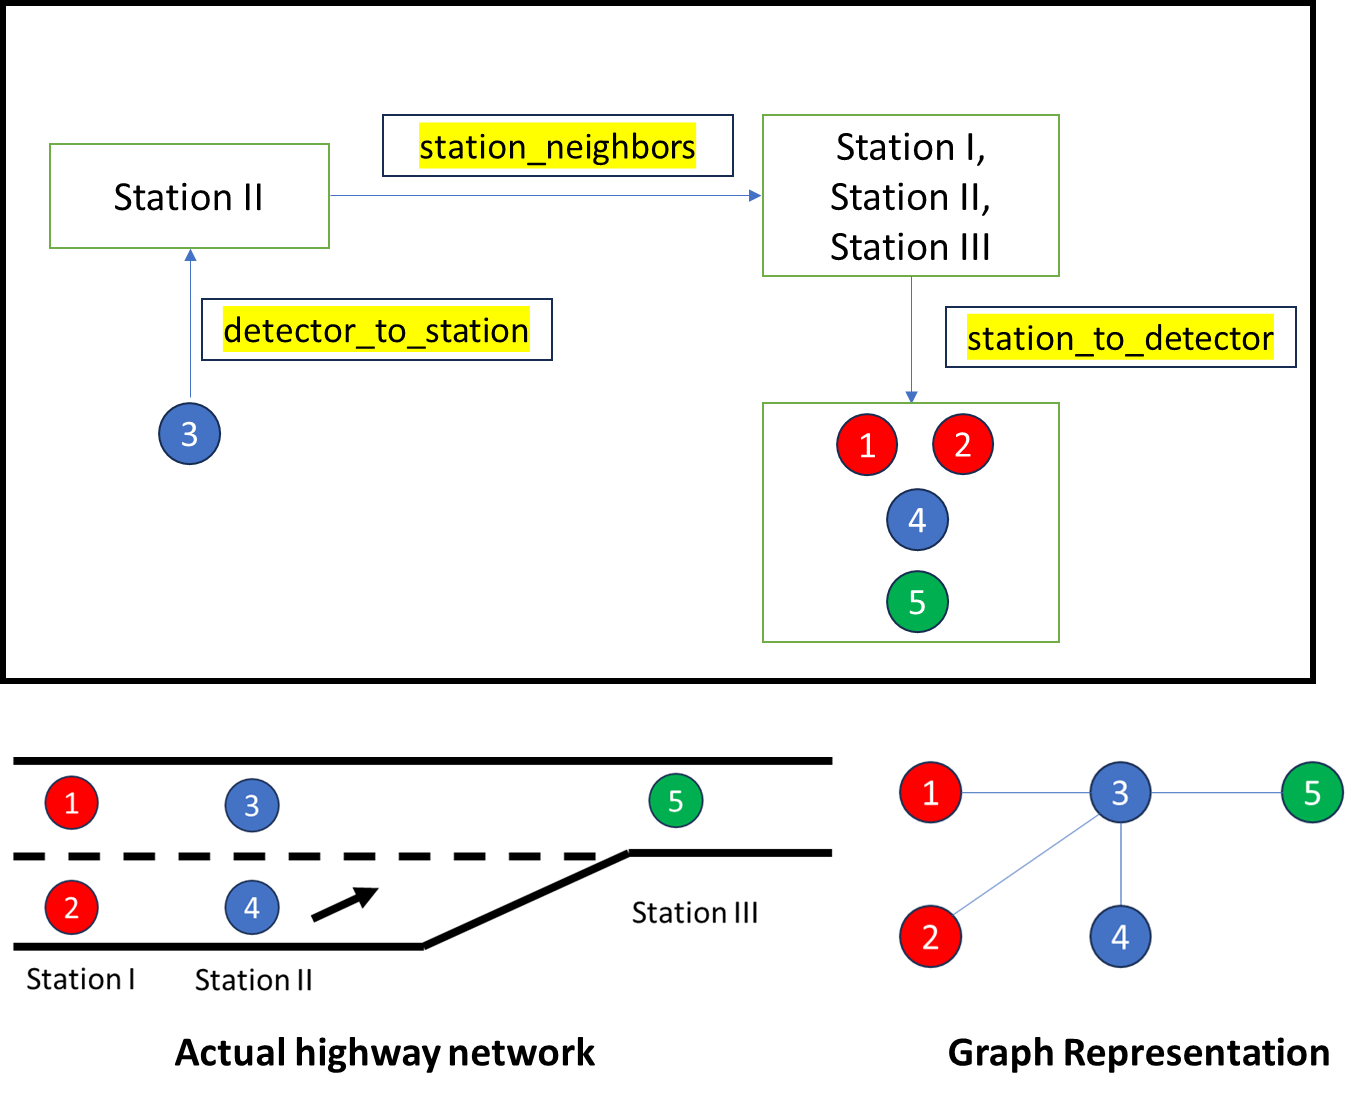

In [6]:
# data_convert_ordered(from_folder, to_folder, station_list, station_to_detector_dict, detector_lane_dict)

In [7]:
import importlib
from model_input_data import *
# import the daily timeseires data as a tensor
# dfs_values: occupancy measurements; dfs_indices: indicator for imputed or not (1: observed, 0: imputed)
dfs_values, dfs_indices = generate_data_tensor(zip_file_list, detector_list)

In [8]:

# from model_input_data import *
# # use this when developing autoencoder alone
# X_train, y_train = create_autoencoder_training_data(dfs_values, neighbor_detectors_dict, detector_list)
# X_train_corrupt, y_train_corrupt = add_noise(X_train, y_train)
# X_train_corrupt.shape, y_train_corrupt.shape
# from sklearn.model_selection import train_test_split
# X_train_corrupt, X_val, y_train_corrupt, y_val = train_test_split(X_train_corrupt, y_train_corrupt, test_size=0.1, random_state=42)


### Input data for autoencoder and GAT
Random and continuous missing is added to generate a good training sample.

In [9]:
from model_input_data import *
X_graph, X_mask  = create_graph_training_data(dfs_values, dfs_indices)
X_autoencoder, y_autoencoder = create_autoencoder_training_data_from_graph_data(X_graph, X_mask, dfs_values, dfs_indices, neighbor_detectors_dict, detector_list)

----------------- Create training data for GAT --------------------
------------- Adding random missing to data ...
------------- Adding block missing to data ...
Finished
----------------- Create training data for Autoencoder --------------------


In [10]:
# train and validataion split for the GAT and Autoencoder
# same training data is used for two methods

train_indices, val_indices, train_indices_autoencoder, val_indices_autoencoder = custom_train_val_split(X_graph.shape[0], X_graph.shape[1])
X_train = X_graph[train_indices]
X_val = X_graph[val_indices]
mask_train = X_mask[train_indices]
mask_val = X_mask[val_indices]

X_train_autoencoder = X_autoencoder[train_indices_autoencoder]
y_train_autoencoder = y_autoencoder[train_indices_autoencoder]
X_val_autoencoder = X_autoencoder[val_indices_autoencoder]
y_val_autoencoder = y_autoencoder[val_indices_autoencoder]


## Autoencoder 

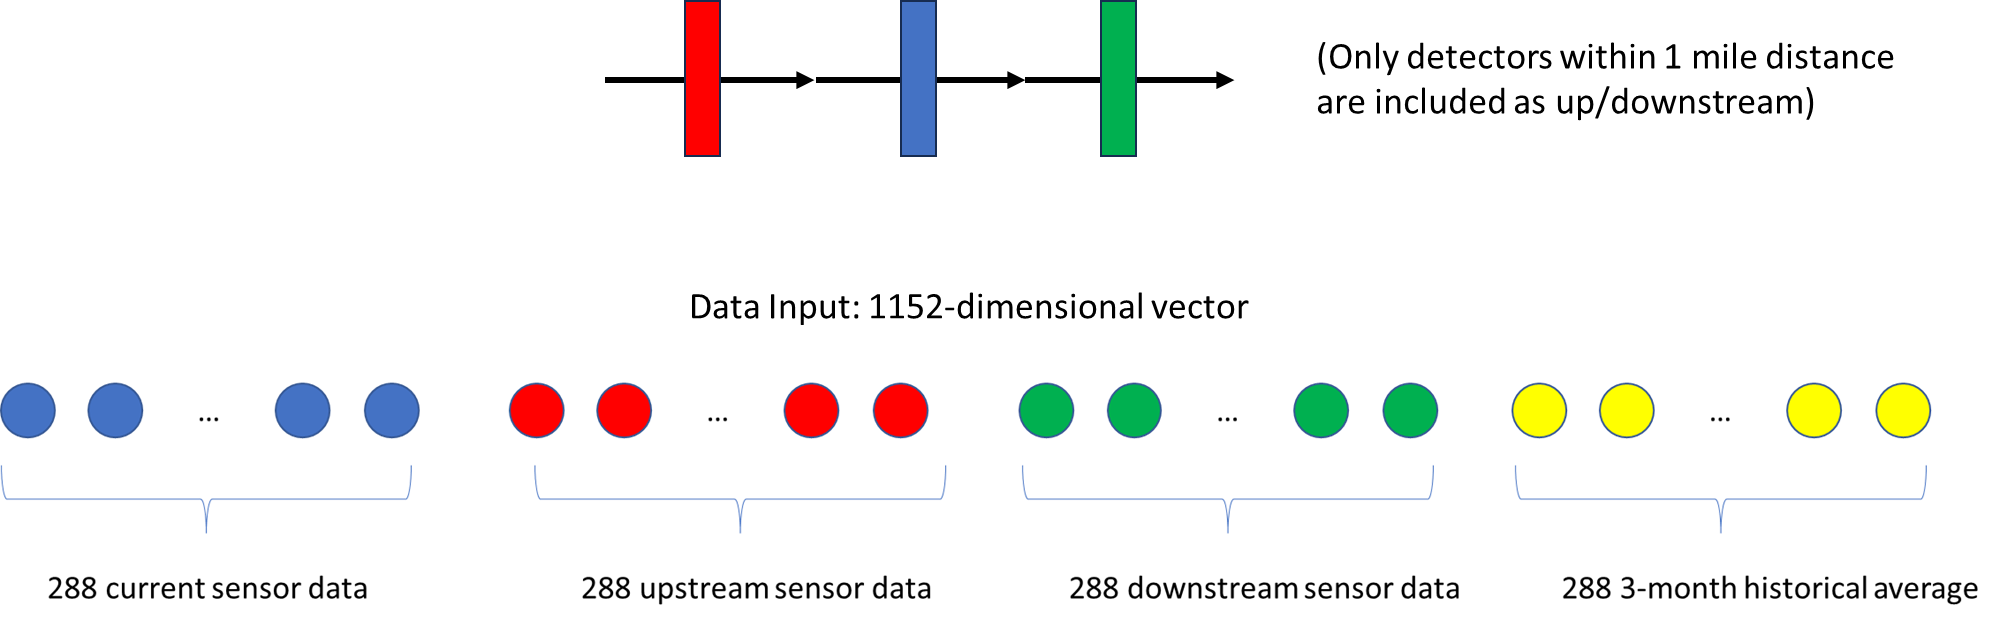

model structure: 
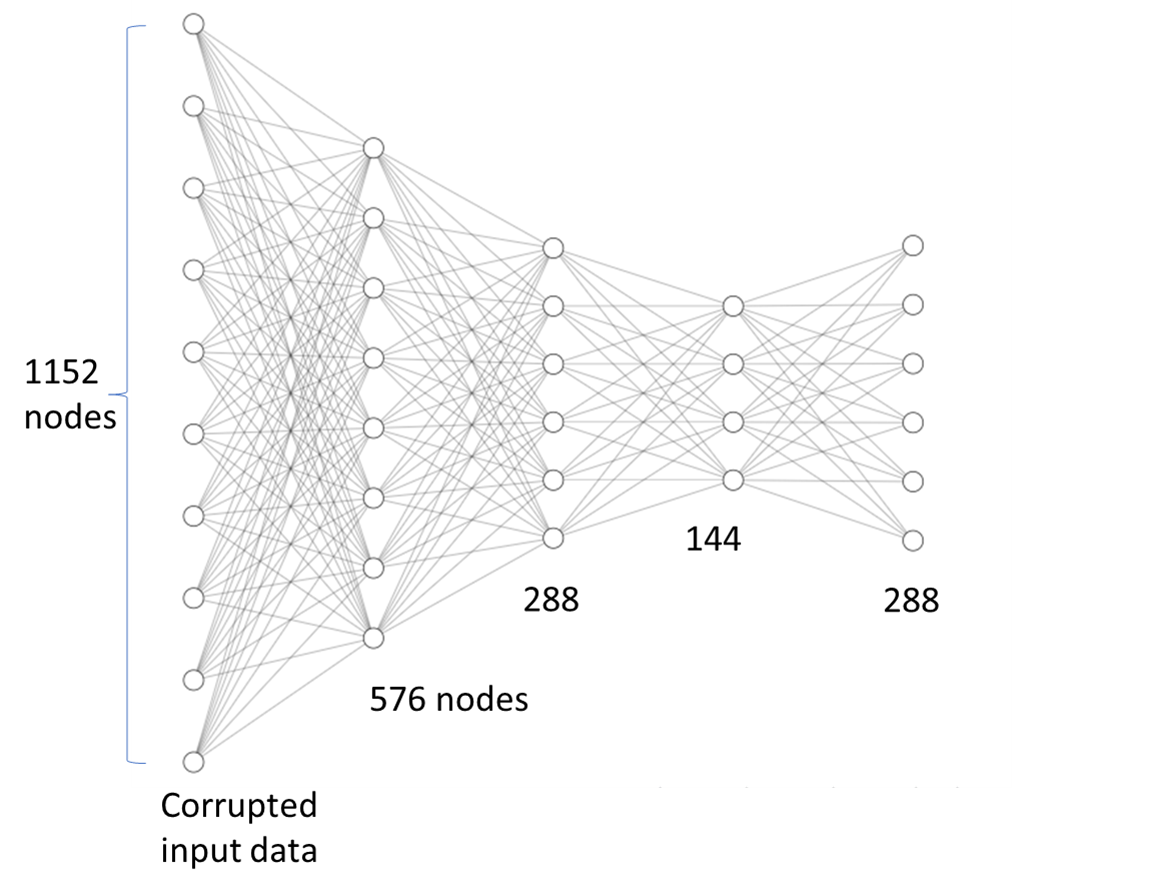

For some reason, the result of this model is not ideal on the proposed autoencoder structure. Instead, we train a simple version of it. (In previous efforts, the autoencoder in above structure is the best performing, maybe more tuning is needed)

In [11]:
from autoencoder_model import *
autoencoder = create_autoencoder_simple(0.1)
autoencoder_history = autoencoder.fit(X_train_autoencoder, y_train_autoencoder, epochs=70, batch_size=64, verbose=1,validation_data=(X_val_autoencoder, y_val_autoencoder))

Epoch 1/70
10184/10184 ━━━━━━━━━━━━━━━━━━━━ 104s 10ms/step - loss: 0.0031 - val_loss: 1.5283e-04
Epoch 2/70
10184/10184 ━━━━━━━━━━━━━━━━━━━━ 101s 10ms/step - loss: 1.8912e-04 - val_loss: 1.1354e-04
Epoch 3/70
10184/10184 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - loss: 1.4955e-04 - val_loss: 1.0744e-04
Epoch 4/70
10184/10184 ━━━━━━━━━━━━━━━━━━━━ 93s 9ms/step - loss: 1.2847e-04 - val_loss: 9.2273e-05
Epoch 5/70
10184/10184 ━━━━━━━━━━━━━━━━━━━━ 90s 9ms/step - loss: 1.1773e-04 - val_loss: 8.1781e-05
Epoch 6/70
10184/10184 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - loss: 1.1145e-04 - val_loss: 7.7555e-05
Epoch 7/70
10184/10184 ━━━━━━━━━━━━━━━━━━━━ 90s 9ms/step - loss: 1.0593e-04 - val_loss: 7.8617e-05
Epoch 8/70
10184/10184 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - loss: 1.0177e-04 - val_loss: 7.3601e-05
Epoch 9/70
10184/10184 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - loss: 9.7885e-05 - val_loss: 6.8020e-05
Epoch 10/70
10184/10184 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - loss: 9.5090e-05 - val_loss: 6.6009e-05
Epoch 11/

Text(0, 0.5, 'Mean squared error loss')

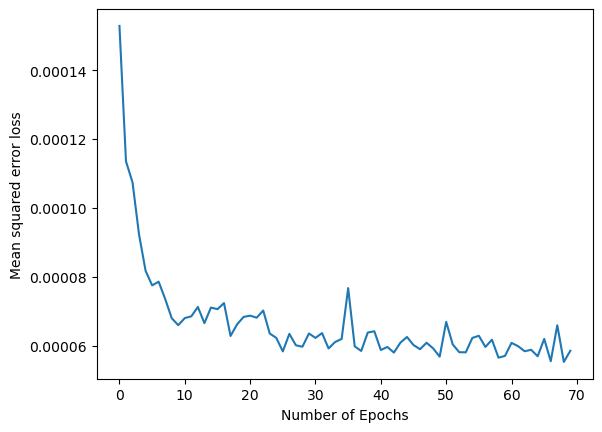

In [12]:
from matplotlib import pyplot as plt
plt.plot(autoencoder_history.history["val_loss"])
plt.xlabel("Number of Epochs")
plt.ylabel("Mean squared error loss")

### Run the GAT model 

In [16]:
# adjacency matrix
A = model_input_data.GAT_adjacency_matrix(detector_list, detector_to_station_dict, station_to_detector_dict, neighbor_stations_dict, neighbor_detectors_dict, consider_two_neighbors=True)

In [17]:
import torch
# Convert NumPy arrays to PyTorch tensors
A = torch.tensor(A, dtype=torch.float32)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
mask_train = torch.tensor(mask_train, dtype=torch.float32)
mask_val = torch.tensor(mask_val, dtype=torch.float32)

In [18]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, mask_train, mask_val = train_test_split(X_graph, X_mask, test_size=0.2, random_state=42)

# Save the tensor to a local file
torch.save(X_train, 'X_train.pt')
torch.save(A, 'A.pt')
torch.save(X_val, 'X_val.pt')
torch.save(mask_train, 'mask_train.pt')
torch.save(mask_val, 'mask_val.pt')

#### Train GAT

In [19]:
import graph_attention_network_model
importlib.reload(graph_attention_network_model)
from graph_attention_network_model import *
GAT_model = train_GAT(A, X_train, X_val, mask_train, mask_val, num_epochs=70)

Epoch 1/70, Loss: 0.0002007113568754655, Validation Loss: 0.00016239388604696804
Epoch 11/70, Loss: 8.843426544097549e-05, Validation Loss: 7.588659170408412e-05
Epoch 21/70, Loss: 7.40966374565191e-05, Validation Loss: 7.164893203438159e-05
Epoch 31/70, Loss: 6.710009424965722e-05, Validation Loss: 6.662029675173344e-05
Epoch 41/70, Loss: 6.281131719548615e-05, Validation Loss: 5.663403493240049e-05
Epoch 51/70, Loss: 6.0431137804037215e-05, Validation Loss: 6.020757826073075e-05
Epoch 61/70, Loss: 5.688995477314827e-05, Validation Loss: 5.729095863010348e-05
Training complete.


In [23]:
# save the model parameters
torch.save(GAT_model.state_dict(), 'GAT_model.pth')
print("Model saved to GAT_model.pth")

Model saved to GAT_model.pth


In [20]:

fitted_values = []  # List to store fitted values for each sample
GAT_model.eval()  # Set model to evaluation mode
edge_index = torch.nonzero(A).t()
with torch.no_grad():  # Disable gradient computation
    for i in range(len(X_val)):
        X_sample = X_val[i]  # Get features for the current sample
        outputs_sample = GAT_model(X_sample, edge_index)
        fitted_values.append(outputs_sample)

# Convert the list of fitted values to a tensor
fitted_values = torch.stack(fitted_values, dim=0)


In [41]:

from model_eval import *
baseline_history_imputation_mse(dfs_values, X_val, mask_val, val_indices)

# Compute the GAT squared error
mse_GAT = torch.mean(F.mse_loss(fitted_values*mask_val, X_val*mask_val, reduction='none'))
print("The MSE of GAT model is,", float(mse_GAT))

The MSE of a naive 3-month historical average imputation is 0.0004394858044683495
The MSE of GAT model is, 5.372327723307535e-05


Autoencoder model has mse: 5.8580e-5. Apparently, the machine learning is valid, at least performing better than the historical average. 

## Create test data - Data in April

In [42]:

# Define the start and end dates
start_date = datetime(2024, 4, 1)
end_date = datetime(2024, 4, 30)

zip_file_list_test = initialize_zip_file_list(start_date, end_date)
# data_convert_ordered(from_folder, to_folder, station_list, station_to_detector_dict, detector_lane_dict)


The current data in `dfs_values_test` contain the imputed data by Caltrans' current imputation methods. We first replace those values with historical average. 

In [167]:
dfs_values_test, dfs_indices_test = generate_data_tensor(zip_file_list_test, detector_list)
dfs_values_test.shape

concatenated_dfs_values = np.concatenate((dfs_values, dfs_values_test), axis=0)    
hist_graph_test = []  # historical measurements average for the test data
for i in range(len(concatenated_dfs_values)-30, len(concatenated_dfs_values)):
    # compute historical dataset as 3 month same-day traffic condition
    hist_graph_test.append(np.mean(concatenated_dfs_values[[i-k*7 for k in range(1, 13)], :, :], axis = 0))
hist_graph_test = np.array(hist_graph_test)

In [168]:
# replace the need-imputation locations with historical average
X_test = np.copy(dfs_values_test)
mask_test = np.copy(dfs_indices_test)
X_test[mask_test==0] = hist_graph_test[mask_test==0] 
X_test = torch.tensor(X_test, dtype=torch.float32)

Use the GAT model to impute the data in April (test dataset):

In [169]:

fitted_values = []  # List to store fitted values for each sample
GAT_model.eval()  # Set model to evaluation mode
edge_index = torch.nonzero(A).t()
with torch.no_grad():  # Disable gradient computation
    for i in range(len(X_test)):
        X_sample = X_test[i]  # Get features for the current sample
        outputs_sample = GAT_model(X_sample, edge_index)
        fitted_values.append(outputs_sample)

# Convert the list of fitted values to a tensor
fitted_values = torch.stack(fitted_values, dim=0)

## Result of the imputation with GAT
In the following figures, we plot several imputed results. The first bar is a black and white bar, with length 288. If data is observed in that sample at a given time step, the bar will be black; otherwise, no data makes it white. 

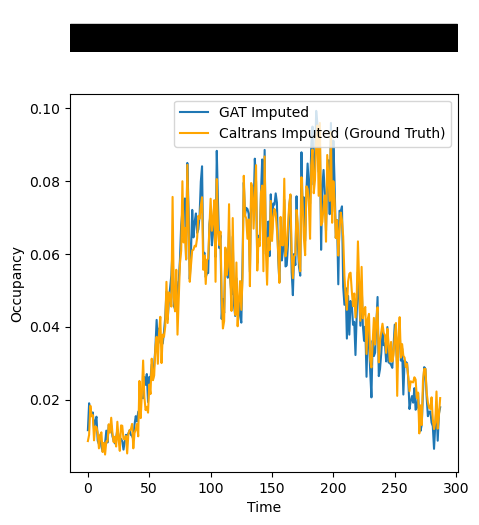

In [186]:
import model_eval
importlib.reload(model_eval)
from model_eval import *

plot_estimation_graph(1, dfs_values_test[0], mask_test[0], fitted_values[0])

In this day, there is no data at all. Here if we have actual data, the ground truth will be in solid lines. If there is no observation, the ground truth will be in dashed line.

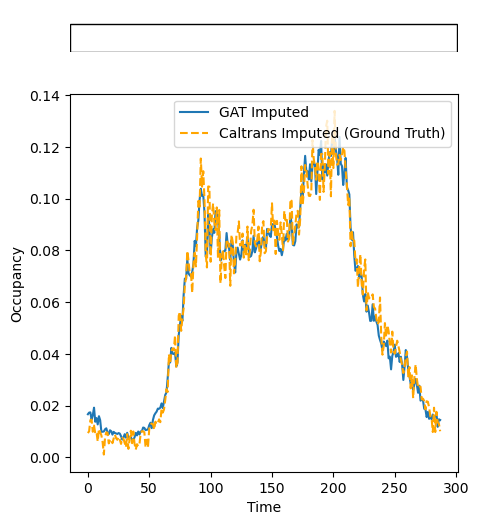

In [187]:
plot_estimation_graph(52, dfs_values_test[0], mask_test[0], fitted_values[0])

Let us also take a look at partially observed locations.

In [188]:
# find a day with partial observation in dfs_values_test[0]
observation_sums = np.sum(dfs_indices_test[0], axis=1)
# Find indices where the sum is between 100 and 200 
np.where((observation_sums > 100) & (observation_sums < 200))


(array([229, 230, 231, 232, 233, 234, 241, 242, 243, 244, 245, 246, 262,
        263, 264, 457, 458, 459, 460, 461, 462], dtype=int64),)

The orange line is the imputed data from Caltrans' current method. Only the solid orange line is the ground truth. The dashed orange line is the imputed part by caltrans. In this sample, the Caltrans current imputation has an obvious discontinuous point where the data becomes available. It implies the current imputation method might suffer from inaccuracy as the imputation differs a lot from the observed data (the ground truth). 

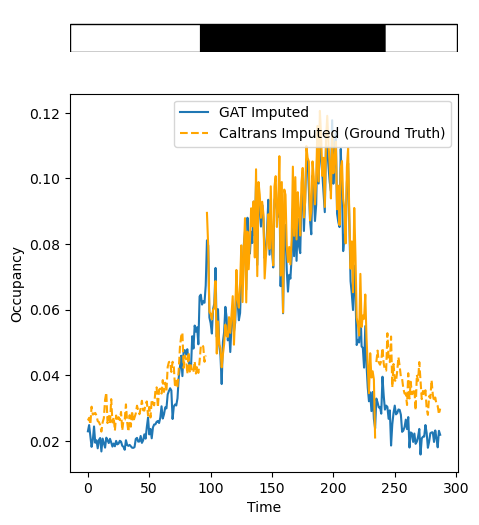

In [203]:
plot_estimation_graph(460, dfs_values_test[0], mask_test[0], fitted_values[0])

Let us take a look at two another samples, we again observe two jumps at the start and end of time period where actual data differs a lot from the imputation. Our GAT model seems have a smooth estimation.


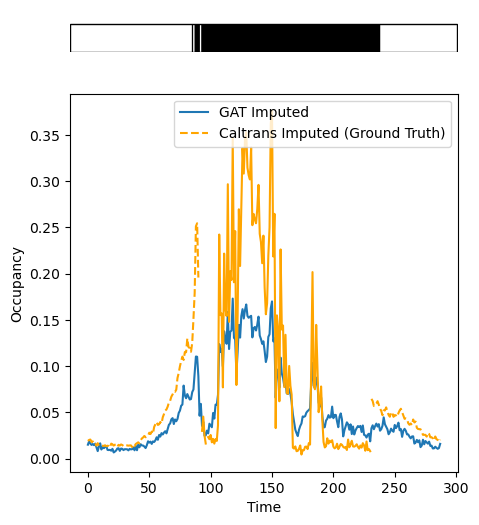

In [211]:
plot_estimation_graph(264, dfs_values_test[0], mask_test[0], fitted_values[0])

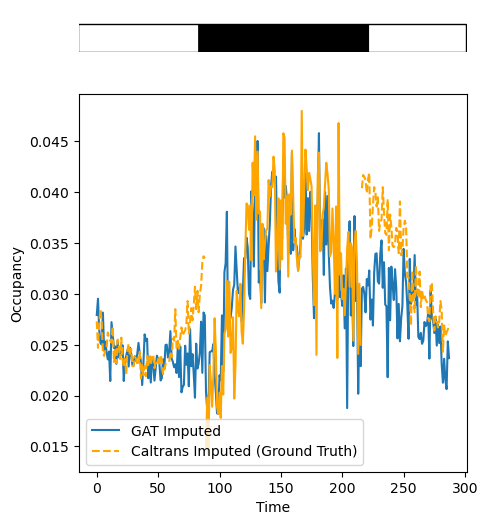

In [210]:
plot_estimation_graph(231, dfs_values_test[20], mask_test[20], fitted_values[20])

#### Summary

The last step of our imputation model is to replace the imputation part with actual data if it is available (replace the solid orange part to the blue part). With this, we can see the current GAT model based imputation seems to produce smoother imputation. The current GAT model can be integrated with more time-series model such as LSTM. 

# Step-by-Step Breakdown of GraphAttentionNetwork with Autoencoder

## 1. Graph Attention Layer (GAT Layer)
The Graph Attention Network (GAT) layer aggregates information from neighboring nodes using an attention mechanism.

Let:
- $X$ be the input node feature matrix of shape $(N, F_{in})$, where $N$ is the number of nodes and $F_{in}$ is the input feature dimension.
- $A$ be the adjacency matrix.
- $W$ be the learnable weight matrix of the GAT layer of shape $(F_{in}, F_{out})$.
- $\alpha_{ij}$ be the attention coefficient between node $i$ and node $j$.

The attention mechanism can be defined as:
$$ \alpha_{ij} = \frac{\exp(\text{LeakyReLU}(a^\top [W X_i \| W X_j]))}{\sum_{k \in \mathcal{N}(i)} \exp(\text{LeakyReLU}(a^\top [W X_i \| W X_k]))} $$

Where:
- $a$ is a learnable weight vector.
- $\|$ denotes concatenation.
- $\mathcal{N}(i)$ is the set of neighbors of node $i$.

The GAT layer output $H$ for node $i$ is computed as:
$$ H_i = \sigma \left( \sum_{j \in \mathcal{N}(i)} \alpha_{ij} W X_j \right) $$

In the case of multi-head attention with $K$ heads, the output is concatenated (or averaged) across the heads:
$$ H_i = \bigg\|_{k=1}^K \sigma \left( \sum_{j \in \mathcal{N}(i)} \alpha_{ij}^{(k)} W^{(k)} X_j \right) $$

## 2. Encoder Layer
The encoder layer reduces the dimensionality of the node features.

Let:
- $H$ be the output of the GAT layer of shape $(N, F_{out})$.
- $W_{enc}$ be the weight matrix of the encoder layer of shape $(F_{out}, F_{latent})$, where $F_{latent}$ is the dimension of the latent space.

The encoder operation is:
$$ Z = H W_{enc} $$

Where:
- $Z$ is the latent representation of shape $(N, F_{latent})$.

## 3. Decoder Layer
The decoder layer reconstructs the node features from the latent representation.

Let:
- $W_{dec}$ be the weight matrix of the decoder layer of shape $(F_{latent}, F_{out})$.

The decoder operation is:
$$ H' = Z W_{dec} $$

Where:
- $H'$ is the reconstructed feature matrix of shape $(N, F_{out})$.

## 4. Output Layer
The output layer maps the reconstructed features back to the original feature dimension.

Let:
- $W_{out}$ be the weight matrix of the output layer of shape $(F_{out}, F_{in})$.

The final output is:
$$ \hat{X} = H' W_{out} $$

Where:
- $\hat{X}$ is the reconstructed input feature matrix of shape $(N, F_{in})$.

## Putting It All Together
The full forward pass of the model is:

1. Apply the GAT layer:
$$ H = \text{ELU}(\text{GATConv}(X, A)) $$

2. Encode to latent space:
$$ Z = H W_{enc} $$

3. Decode to reconstruct:
$$ H' = \text{ELU}(Z W_{dec}) $$

4. Map to original feature space:
$$ \hat{X} = H' W_{out} $$

## Loss Function
The loss function compares the reconstructed features $\hat{X}$ with the original features $X$, considering only known values (as indicated by the mask):

$$ \mathcal{L} = \text{MSE}(\hat{X} \cdot M, X \cdot M) $$

Where:
- $M$ is the mask matrix indicating known values.
- $\cdot$ denotes element-wise multiplication.

This ensures the model focuses on accurately reconstructing only the known values, improving its ability to handle incomplete data.
